# Bidirectional Quantum Refrigerators (BQR)

In the following code, I will show how the two Bidirectional Quantum Refrigeratos (BQR) protocols from the paper *Improving Quantum Machine Learning via Heat-Bath Algorithmic Cooling* (Rodriguez-Briones, Park, 2025) work, as well as comparing the achieved results between them, and those obtained in the original paper.

Starting from the core, we will import the required libraries

In [ ]:
!pip install pennylane --upgrade
!pip install pennylane-qiskit

In [ ]:
import random
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as np

# Part one: coming up with a high-entropy system

This block of code will generate a batch of qubits, then apply an operation to increase their entropy and lower its polarization (which will both be stored in a variable)

In [ ]:
#Given a certain number of new qubits, what we'll do first is to randomly rotate
#them, so as to increase the system's entropy and reduce its polarization
#lastly, we will compute the density matrix of a single qubit, so that we can measure

num_qubits = 10
dev = qml.device("default.qubit", wires=num_qubits) #This is our batch

# Define the quantum circuit.
@qml.qnode(dev)

def qubits_batch(n):
    for i in range(n):
        qml.RandomLayers(weights=np.random.rand(5, n), wires=range(n))

    return qml.density_matrix(wires=[0])

rho = qubits_batch(num_qubits)

In [ ]:
#Given the qubits batch and its density matrix, this function computes
#the system's entropy, and with it the polarization by computing
#the trace of the product between the entropy and the Pauli Z operator

def entropy_polarization(density):
  eigvals = np.linalg.eigvalsh(density)
  eigvals = np.clip(eigvals, 0, 1)
  entropy = -np.sum(eigvals * np.log2(eigvals + 1e-10))

  sigma_z = np.array([[1, 0], [0, -1]])
  if density.shape != (2, 2):
      from qutip import Qobj, ptrace  # or custom partial trace logic
      density = ptrace(Qobj(density), 0).full()

  polarization = np.real(np.trace(density @ sigma_z))

  return entropy, polarization

By this point, we have a batch of qubits in a high entropy state, and low polarization.

The variable ***dev***  "holds" our qubit batch

# Part two: building our protocols

# Our building blocks

The function *unitary* will allow us to build our unitary acting over n-wires as the diagram from Fig. 3 shows us.



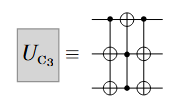


In [ ]:
def cxx_gate(n):
  for i in range(1, n):
    qml.CNOT(wires=[0, i])  # Control = qubit 0, Target = all other qubits, one by one

In [ ]:
def unitary(n): #where n is the total handful of qubits to act upon

    # First layer: CXX gate
    cxx_gate(n)
    # Second layer: MultiControlledX
    qml.MultiControlledX(wires=[i for i in range(0,n)])
    # Third layer: CXX gate
    cxx_gate(n)

# Defining one round for our BQR

Now we need to define our architecture.

For the first BQR protocol, we start with our qubits (wires) on a high entropy state, then we pass them through unitaries of increasing size, until we cover all of the wires, to finally reset the qubits from the last m wires.

This is defined as one round. In order to replicate the original paper, we will keep n = 5, m = 2, and vary the number of rounds, although the unitaries and the architecture will be built in a general manner, to easily change parameters.

The iteration of one round is ilustrated in this diagram

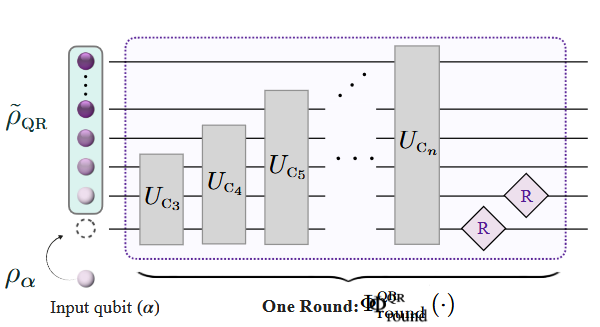

In [ ]:
#Building the architecture for one round with n qubits and m reset qubits

def round(n, m):

    #As per the paper, we start with a unitary acting on 3 wires
    #then we loop our way to cover all of them
    for i in range(3, n+1):
      unitary(n)

    #After having passed through all of the unitaries, we reset m qubits
    for j in range(m):
      qml.Hadamard(wires= n-j-1)  # Put qubit in superposition
      m = qml.measure(n-j-1)  # Measure the qubit (collapsing it)
      qml.cond(m, qml.PauliX)(wires=n-j-1)


# All together

This dictionary will help us plot the results

In [ ]:
results = {
    "rounds": [],  # Number of rounds
    "initial_entropy": [],
    "final_entropy": [],
    "initial_polarization": [],
    "final_polarization": []
}

This function encapsules the whole round process of the first protocol seen in the paper, chaining the previously defined functions

In [ ]:
N_rounds = 3
n = num_qubits
m = 2

@qml.qnode(dev)
def first_protocol(N_rounds, qubits, reset_q):
    for i in range(N_rounds):
        round(qubits, reset_q)
    return qml.density_matrix(wires=[0])

rho_new = first_protocol(N_rounds, n, m)

And in this block, we have the whole process automated for the different amount of rounds we want to test. Notice how the protocol function is ciclical, and for each amount of rounds, the qubit batch is restarted before passing through the protocol again

In [ ]:
n = num_qubits
m = 2

@qml.qnode(dev)

def first_protocol(N_rounds, qubits, reset_q):
    for i in range(N_rounds):
        round(qubits, reset_q)
    return qml.density_matrix(wires=[0])


#Here we automate the whole process for the first protocol
for N_rounds in range(3,9):

  #start the batch and randomly rotate it
  rho = qubits_batch(num_qubits)

  #compute the polarization and entropy
  entropy_polarization(rho)

  #store the variables in a dictionary
  results["initial_entropy"].append(entropy_polarization(rho)[0])
  results["initial_polarization"].append(entropy_polarization(rho)[1])

  #pass the high-entropy batch across the protocol
  rho_new = first_protocol(N_rounds, n, m)

  #re-compute entropy and polarization
  entropy_polarization(rho_new)

  #append the values into the dict
  results["final_entropy"].append(entropy_polarization(rho_new)[0])
  results["final_polarization"].append(entropy_polarization(rho_new)[1])
  results["rounds"].append(N_rounds)

In [ ]:
results

{'rounds': [3, 4, 5, 6, 7, 8],
 'initial_entropy': [np.float64(0.9990975277729561),
  np.float64(0.9968925335277621),
  np.float64(0.9984782211866385),
  np.float64(0.9981968925338058),
  np.float64(0.9971458982296645),
  np.float64(0.9981215398630439)],
 'final_entropy': [np.float64(-1.442691956759448e-10),
  np.float64(-1.442691956759448e-10),
  np.float64(-1.442691956759448e-10),
  np.float64(-1.442691956759448e-10),
  np.float64(-1.442691956759448e-10),
  np.float64(-1.442691956759448e-10)],
 'initial_polarization': [np.float64(0.011011802543529237),
  np.float64(0.019302134705168894),
  np.float64(-0.027958964645297124),
  np.float64(-0.024948419719093784),
  np.float64(-0.008787766975990208),
  np.float64(0.043896706889863746)],
 'final_polarization': [np.float64(0.9999999999999999),
  np.float64(0.9999999999999999),
  np.float64(0.9999999999999999),
  np.float64(0.9999999999999999),
  np.float64(0.9999999999999999),
  np.float64(0.9999999999999999)]}

# Second protocol

According to the original paper, this protocol doesn't polarize as much as the previous one, but it's easier to implement on a larger scale.

We are going to use the same circuit function, and the only change will be on the round function. Instead of increasing each unitary in size, it should just shift one wire up constantly until it gets to the other side.

Once again, we define a dictionary first

In [ ]:
results_second = {
    "rounds": [],  # Number of rounds
    "initial_entropy": [],
    "final_entropy": [],
    "initial_polarization": [],
    "final_polarization": []
}


In [ ]:
#We repeat the same batch creation procedure as before

num_qubits = 10
dev = qml.device("default.qubit", wires=num_qubits) #This is our batch

# Define the quantum circuit.
@qml.qnode(dev)

def qubits_batch(n):
    for i in range(n):
        qml.RandomLayers(weights=np.random.rand(5, n), wires=range(n))

    return qml.density_matrix(wires=[0])

rho = qubits_batch(num_qubits)

Based on the same building blocks from the previous protocol, we define the ones for the second protocol. This time, we just need to adapt them to stay the same size, but navigate through the different wires.

In [ ]:
def cxx_gate_staircase(n):
    qml.CNOT(wires=[n, n + 1])
    qml.CNOT(wires=[n, n + 2])   # This so that we can staircase this n=3 unitary

def unitary_staircase(n): #where n is the "top" qubit

    # First layer: CXX gate
    cxx_gate(n)
    # Second layer: MultiControlledX. Now the size if fixed for 3 wires, we only adapt it to shift across the batch
    qml.MultiControlledX(control_wires=[n+1, n+2], wires=n)
    # Third layer: CXX gate
    cxx_gate(n)

In [ ]:
#Building the architecture for one round with n qubits and m reset qubits

def round_staircase(n, m):

    #As per the paper, we start with our n=3 unitary on the bottom part of the
    #batch, then move it one wire at a time
    for i in range(n-2, -1, -1): #reverse loop to cover the wire 0
      unitary_staircase(n)

    #After having passed through all of the unitaries, we reset m qubits. The diagram shows the same 2 wires for both protocols
    for j in range(m):
      qml.Hadamard(wires= n-j-1)  # Put qubit in superposition
      m = qml.measure(n-j-1)  # Measure the qubit (collapsing it)
      qml.cond(m, qml.PauliX)(wires=n-j-1)


In [ ]:
N_rounds = 3
n = num_qubits
m = 2

@qml.qnode(dev)
def second_protocol(N_rounds, qubits, reset_q):
    for i in range(N_rounds):
        round(qubits, reset_q)
    return qml.density_matrix(wires=[0])


#Here we automate the whole process for the first protocol
for N_rounds in range(3,9):

  #start the batch and randomly rotate it
  rho = qubits_batch(num_qubits)
  #compute polarization and entropy
  entropy_polarization(rho)

  #store the variables in the dictionary
  results_second["initial_entropy"].append(entropy_polarization(rho)[0])
  results_second["initial_polarization"].append(entropy_polarization(rho)[1])

  #Now we pass the high-entropy batch across the protocol
  rho_new = second_protocol(N_rounds, n, m)

  #re-compute entropy and polarization
  entropy_polarization(rho_new)

  #append values into the dictionary
  results_second["final_entropy"].append(entropy_polarization(rho_new)[0])
  results_second["final_polarization"].append(entropy_polarization(rho_new)[1])
  results_second["rounds"].append(N_rounds)

We can calculate the entropy and polarization after, and then store the data in order to graph it.

In [ ]:
results_second

{'rounds': [3, 4, 5, 6, 7, 8],
 'initial_entropy': [np.float64(0.9978011412753499),
  np.float64(0.9984495129560519),
  np.float64(0.9898317862871087),
  np.float64(0.998807001114598),
  np.float64(0.9985855530348007),
  np.float64(0.9984064154279959)],
 'final_entropy': [np.float64(-1.442691956759448e-10),
  np.float64(-1.442691956759448e-10),
  np.float64(-1.442691956759448e-10),
  np.float64(-1.442691956759448e-10),
  np.float64(-1.442691956759448e-10),
  np.float64(-1.442691956759448e-10)],
 'initial_polarization': [np.float64(-0.03609354133373355),
  np.float64(0.03143050323114799),
  np.float64(0.0022301296234868984),
  np.float64(-0.01705711376744873),
  np.float64(-0.03987433352445585),
  np.float64(-0.041571437584998094)],
 'final_polarization': [np.float64(0.9999999999999999),
  np.float64(0.9999999999999999),
  np.float64(0.9999999999999999),
  np.float64(0.9999999999999999),
  np.float64(0.9999999999999999),
  np.float64(0.9999999999999999)]}

# Plotting

After running each protocol to compare and contrast different amount of rounds, we can now graph out results and see how they compare to the original paper. We can expect key differences, as this model was built on scale.

# First protocol

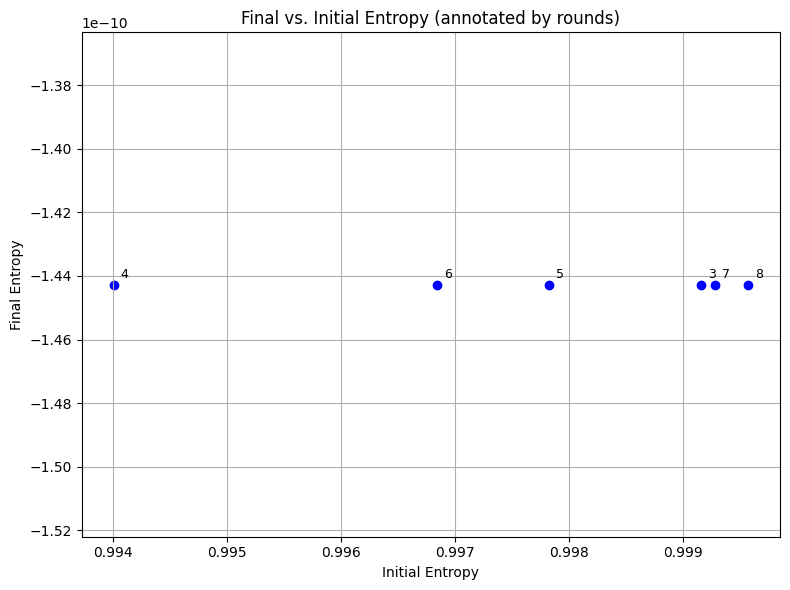

In [ ]:
x = results['initial_entropy']
y = results['final_entropy']
labels = results['rounds']

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c='blue')

for i, label in enumerate(labels):
    plt.annotate(f'{label}', (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)

plt.xlabel('Initial Entropy')
plt.ylabel('Final Entropy')
plt.title('Final vs. Initial Entropy (annotated by rounds)')
plt.grid(True)
plt.tight_layout()
plt.show()

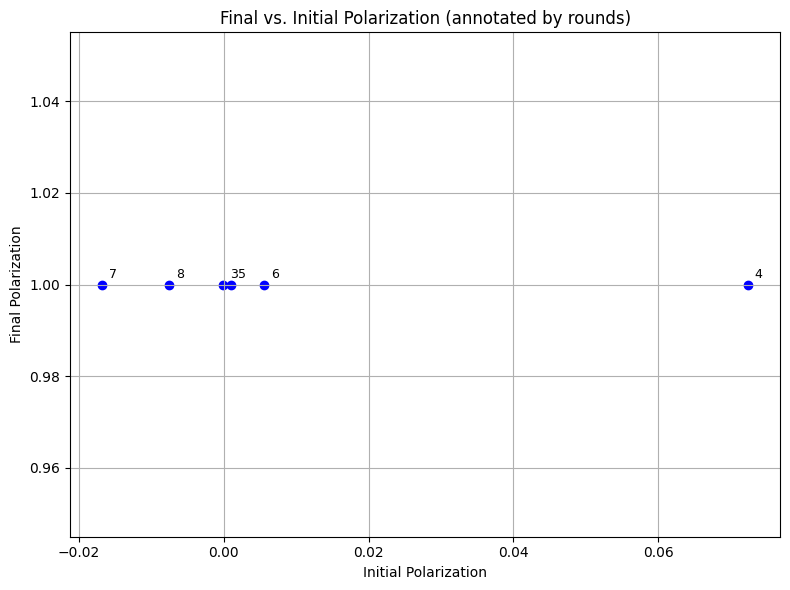

In [ ]:
x = results['initial_polarization']
y = results['final_polarization']
labels = results['rounds']

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c='blue')

for i, label in enumerate(labels):
    plt.annotate(f'{label}', (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)

plt.xlabel('Initial Polarization')
plt.ylabel('Final Polarization')
plt.title('Final vs. Initial Polarization (annotated by rounds)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Now for the second protocol

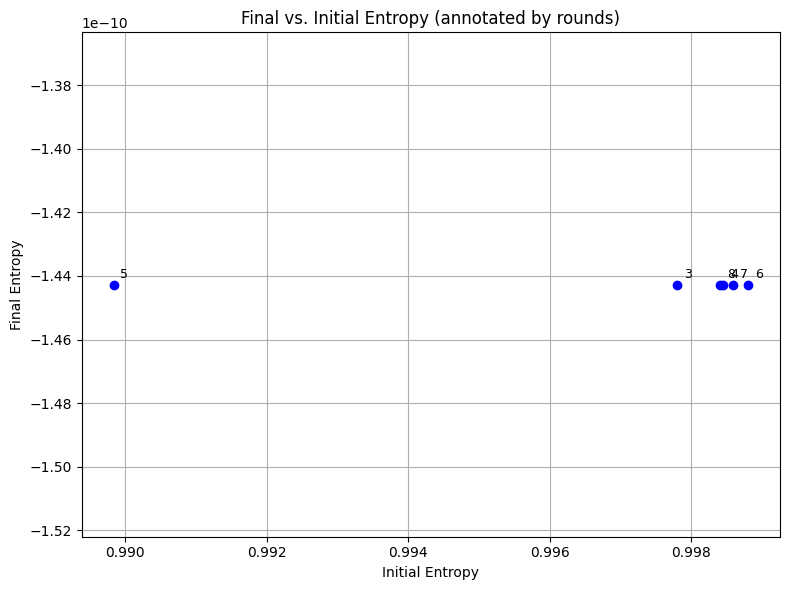

In [ ]:
x = results_second['initial_entropy']
y = results_second['final_entropy']
labels = results_second['rounds']

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c='blue')

for i, label in enumerate(labels):
    plt.annotate(f'{label}', (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)

plt.xlabel('Initial Entropy')
plt.ylabel('Final Entropy')
plt.title('Final vs. Initial Entropy (annotated by rounds)')
plt.grid(True)
plt.tight_layout()
plt.show()

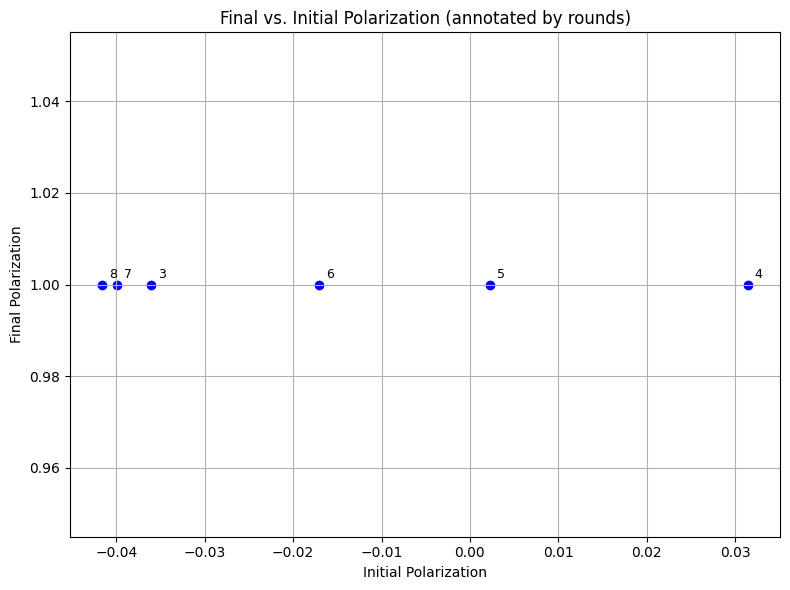

In [ ]:
x = results_second['initial_polarization']
y = results_second['final_polarization']
labels = results_second['rounds']

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c='blue')

for i, label in enumerate(labels):
    plt.annotate(f'{label}', (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)

plt.xlabel('Initial Polarization')
plt.ylabel('Final Polarization')
plt.title('Final vs. Initial Polarization (annotated by rounds)')
plt.grid(True)
plt.tight_layout()
plt.show()